# Example application: computing the tree canopy for the Aussersihl district in Zurich

In this example, we will compute a binary tree canopy map for the [Aussersihl district](https://en.wikipedia.org/wiki/Aussersihl) in Zurich. In order to avoid issues with relative paths, let us first of all change the working directory to the repository's root.

In [1]:
%cd ..

c:\Users\marin\Documents\_MJMS\Dev\detectree-example-IL


In [2]:
import os
from os import path

import detectree as dtr
import geopandas as gpd
import rasterio as rio
from rasterio import merge

from detectree_example import make_response_tiles, plot_utils, settings

Let us now use the Makefile at the root of this repository ensure that we have the required data inputs - i.e., the required tiles from Zurich's RGB orthophoto of summer 2014/15 that lie within Zurich's municipal boundaries - have been downloaded (see the background notebook for more details).

In [4]:
!make aussersihl_tiles

mkdir data\raw
mkdir data\raw\orthoimg
wget https://maps.zh.ch/download/orthofoto/sommer/2014/rgb/jpeg/ortho_sommer14.dbf -O data\raw\orthoimg\ortho_sommer14.dbf
wget https://maps.zh.ch/download/orthofoto/sommer/2014/rgb/jpeg/ortho_sommer14.prj -O data\raw\orthoimg\ortho_sommer14.prj
wget https://maps.zh.ch/download/orthofoto/sommer/2014/rgb/jpeg/ortho_sommer14.shx -O data\raw\orthoimg\ortho_sommer14.shx
wget https://maps.zh.ch/download/orthofoto/sommer/2014/rgb/jpeg/ortho_sommer14.shp -O data\raw\orthoimg\ortho_sommer14.shp
mkdir data\interim
mkdir data\interim\aussersihl_tiles
python detectree_example\get_tiles_to_download.py data\raw\orthoimg\ortho_sommer14.shp \
	"Zurich Aussersihl" data\interim\aussersihl_tiles\intersecting_tiles.csv --op intersects
python detectree_example\make_tiles.py data\interim\aussersihl_tiles\intersecting_tiles.csv data\interim\aussersihl_tiles data\interim\aussersihl_tiles\tiles.csv \
	--nominatim-query "Zurich Aussersihl" \
	--exclude-nominatim-query "La

process_begin: CreateProcess(NULL, seq 0 $((4-1)), ...) failed.
Makefile:132: pipe: No error
--2023-03-19 21:51:51--  https://maps.zh.ch/download/orthofoto/sommer/2014/rgb/jpeg/ortho_sommer14.dbf
Resolving maps.zh.ch (maps.zh.ch)... 193.246.69.8
Connecting to maps.zh.ch (maps.zh.ch)|193.246.69.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 164795 (161K)
Saving to: 'data/raw/orthoimg/ortho_sommer14.dbf'

     0K .......... .......... .......... .......... .......... 31% 43.7K 3s
    50K .......... .......... .......... .......... .......... 62%  134K 1s
   100K .......... .......... .......... .......... .......... 93% 84.0K 0s
   150K ..........                                            100% 4.32M=2.1s

2023-03-19 21:51:56 (76.1 KB/s) - 'data/raw/orthoimg/ortho_sommer14.dbf' saved [164795/164795]

--2023-03-19 21:51:56--  https://maps.zh.ch/download/orthofoto/sommer/2014/rgb/jpeg/ortho_sommer14.prj
Resolving maps.zh.ch (maps.zh.ch)... 193.246.69.8
Connecti

## Train/test split

The `make` target above will store the required tiles in the 'data/interim/aussersihl_tiles' directory, which we will pass to the [`TrainingSelector`](https://detectree.readthedocs.io/en/latest/train_test_split.html#detectree.TrainingSelector.__init__) initialization method. For this example, we will use the ['cluster-I'](https://github.com/martibosch/detectree-example/blob/master/notebooks/cluster-I.ipynb) method (see Yang et al. [1]) to select the tiles that will be used to train the tree pixel classifier.

In [5]:
ts = dtr.TrainingSelector(img_dir='data/interim/aussersihl_tiles')
split_df = ts.train_test_split(method='cluster-I')

[########################################] | 100% Completed | 14.55 s


c:\Users\marin\anaconda3\envs\detectree\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\marin\anaconda3\envs\detectree\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


## Interlude: computing the responses from LIDAR data

Since detectree uses a supervised learning approach, we need to manually provide the responses (i.e., binary images representing the ground-truth tree/non-tree masks) for the training tiles so that the tree/non-tree pixel classifier can be trained. 

There are many ways to obtain such masks, the most straight-forward being manual edition in a raster graphics editor software such as [GIMP](https://www.gimp.org/). In the case of this example dataset, the ground-truth masks can be extracted from [Zurich's 2014 LIDAR dataset](https://www.geolion.zh.ch/geodatensatz/show?gdsid=343). Such task is accomplished in the two cells below, whose content is out of the scope of detectree.

In [6]:
!make download_lidar_shp

mkdir data\raw\lidar
wget https://maps.zh.ch/download/hoehen/2014/lidar/lidar2014.dbf -O data\raw\lidar\lidar2014.dbf
touch data\raw\lidar\lidar2014.dbf
Touching data\raw\lidar\lidar2014.dbf
wget https://maps.zh.ch/download/hoehen/2014/lidar/lidar2014.prj -O data\raw\lidar\lidar2014.prj
touch data\raw\lidar\lidar2014.prj
Touching data\raw\lidar\lidar2014.prj
wget https://maps.zh.ch/download/hoehen/2014/lidar/lidar2014.qix -O data\raw\lidar\lidar2014.qix
touch data\raw\lidar\lidar2014.qix
Touching data\raw\lidar\lidar2014.qix
wget https://maps.zh.ch/download/hoehen/2014/lidar/lidar2014.shx -O data\raw\lidar\lidar2014.shx
touch data\raw\lidar\lidar2014.shx
Touching data\raw\lidar\lidar2014.shx
wget https://maps.zh.ch/download/hoehen/2014/lidar/lidar2014.shp -O data\raw\lidar\lidar2014.shp
touch data\raw\lidar\lidar2014.shp
Touching data\raw\lidar\lidar2014.shp


process_begin: CreateProcess(NULL, seq 0 $((4-1)), ...) failed.
Makefile:133: pipe: No error
--2023-03-19 22:46:28--  https://maps.zh.ch/download/hoehen/2014/lidar/lidar2014.dbf
Resolving maps.zh.ch (maps.zh.ch)... 193.246.69.8
Connecting to maps.zh.ch (maps.zh.ch)|193.246.69.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1175482 (1.1M)
Saving to: 'data/raw/lidar/lidar2014.dbf'

     0K .......... .......... .......... .......... ..........  4% 42.3K 26s
    50K .......... .......... .......... .......... ..........  8%  231K 15s
   100K .......... .......... .......... .......... .......... 13%  219K 11s
   150K .......... .......... .......... .......... .......... 17%  228K 9s
   200K .......... .......... .......... .......... .......... 21%  147K 8s
   250K .......... .......... .......... .......... .......... 26% 2.73M 6s
   300K .......... .......... .......... .......... .......... 30%  113K 6s
   350K .......... .......... .......... .......... ..

In [7]:
lidar_gdf = gpd.read_file('data/raw/lidar/lidar2014.shp')

response_dir = 'data/interim/aussersihl_response-tiles'
if not path.exists(response_dir):
    os.mkdir(response_dir)

response_tiles = make_response_tiles.make_response_tiles(
    split_df, lidar_gdf, 'data/raw/lidar', response_dir)

## Training the classifier

We can now proceed to the training of the classifier. In detectree, this can be done with the `train_classifier` method of the `ClassifierTrainer` class, which accepts the train/test split data frame as the `split_df` keyword argument (see [its documentation](https://detectree.readthedocs.io/en/latest/pixel_classification.html#detectree.ClassifierTrainer.train_classifier) for more details). Note that the training of the classifier can take some time.

In [8]:
clf = dtr.ClassifierTrainer().train_classifier(split_df=split_df,
                                               response_img_dir=response_dir)

[########################################] | 100% Completed | 2.14 ss


## Predicting tree/non-tree labels

Once the classifier has been trained, it can be used to predict the tree/non-tree labels from any given tile. We will first create a directory where the predicted tiles will be dumped:

In [9]:
output_dir = 'data/interim/aussersihl_pred-tiles'
if not path.exists(output_dir):
    os.mkdir(output_dir)

We can use the `classify_imgs` method of the `Classifier` class, which will predict the tree/non-tree labels for all the testing tiles of `split_df` (see [its documentation](https://detectree.readthedocs.io/en/latest/pixel_classification.html#detectree.Classifier.classify_imgs) for more details).

In [10]:
c = dtr.Classifier()

pred_tiles = c.classify_imgs(split_df, output_dir=output_dir, clf=clf)

[########################################] | 100% Completed | 159.60 s


## Saving the tree canopy map as a single GeoTIFF file

Once we have tree pixels of all tiles, we can use the [`merge` function](https://rasterio.readthedocs.io/en/latest/api/rasterio.merge.html?highlight=merge#rasterio.merge.merge) of rasterio to assemble all the tiles into a single file, i.e., the binary tree canopy map.

We will first get a list of all the tree/non-tree tiles, i.e., the ones used for training (`response_tiles`) and the ones used for testing (`pred_tiles`), then read them with rasterio and pass them to the `merge` function:

In [11]:
canopy_tiles = pred_tiles + response_tiles

canopy_arr, canopy_transform = merge.merge(
    [rio.open(canopy_tile) for canopy_tile in canopy_tiles])

We can now plot the result over a basemap (provided by means of the [contextily](https://github.com/geopandas/contextily) library):

<Axes: >

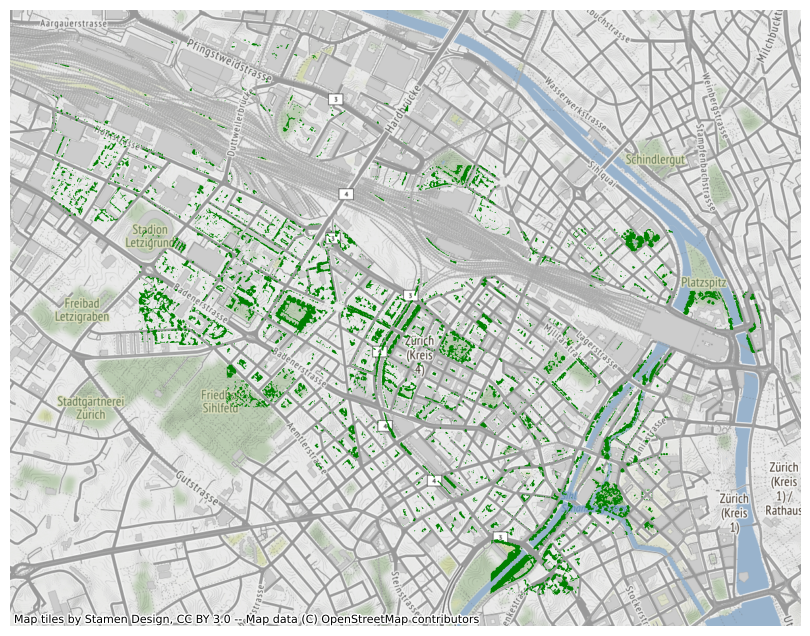

In [12]:
plot_utils.plot_canopy(canopy_arr, canopy_transform, figsize=(12, 8))

Finally, we can use rasterio to dump the tree canopy array to a GeoTIFF file:

In [13]:
output_dir = 'data/processed'
if not path.exists(output_dir):
    os.mkdir(output_dir)

output_canopy_filepath = path.join(output_dir, 'aussersihl_canopy.tif')
output_dtype = rio.uint8

with rio.open(output_canopy_filepath,
              'w',
              driver='GTiff',
              width=canopy_arr.shape[2],
              height=canopy_arr.shape[1],
              count=1,
              crs=settings.CRS,
              transform=canopy_transform,
              dtype=output_dtype) as dst:
    dst.write(canopy_arr.astype(output_dtype))

## References

1. Yang, L., Wu, X., Praun, E., & Ma, X. (2009). Tree detection from aerial imagery. In Proceedings of the 17th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems (pp. 131-137). ACM.